<a href="https://colab.research.google.com/github/rashmi0888/Deep-Learning/blob/master/CNN/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3D Convolutional Neural Network for CIFAR-10 Dataset

### Import relevant components

In [0]:
from __future__ import print_function
import keras
import numpy as np
import matplotlib.pyplot as plt
import itertools
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import CSVLogger
from keras import backend as K
np.random.seed(100)
# Disable warnings
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

### Data Preparation
#### 1. Data Dimensions
CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6000 images per class. There are 50,000 training images and 10,000 test images. Shape of data is (60000, 32, 32, 3).




In [0]:
img_rows, img_cols = 32, 32
num_output_classes = 10

#### 2. Download Data
 Download data from keras dataset.
 

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

#### 3. Reshape and Normalize Data
In Keras, layers used for 3D convolution expect pixel values with dimensions $[width][height][depth][channel]$. 
Hence reshape data to be $[samples][width][height][depth][channel]$. Consider 3(for RGB) as depth and add channel = 1

In [0]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols, 3)
    input_shape = (1, img_rows, img_cols, 3)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3, 1)
    input_shape = (img_rows, img_cols, 3, 1)


X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.astype('float32')
X_test /= 255

#### 4. One hot encoding

In [0]:
Y_train = keras.utils.to_categorical(Y_train, num_output_classes)
Y_test = keras.utils.to_categorical(Y_test, num_output_classes)

#### 5. Shuffle Data

In [6]:
random_index = np.random.permutation(X_train.shape[0])
X_train, Y_train = X_train[random_index], Y_train[random_index]

print('Shape of training samples:', X_train.shape)
print('No of training samples: ', X_train.shape[0])
print('No of test samples: ', X_test.shape[0])

Shape of training samples: (50000, 32, 32, 3, 1)
No of training samples:  50000
No of test samples:  10000


### Train Model
#### 1. Build model
1. Build a CNN configuration having
 * 1 CONV layer using 32 filters of size 3x3x3
 * 1 Maxpool layer using filters of size 2x2x1
 * 1 Fully Connected layer with 128 units

#### 2. Compile model
1. After building model, configure the learning process.
2. Adam optimizer is used.

#### 3. Fit model
1. Fit the model built above into the data.
2. Out of 50,000 traning samples, use 8,000 samples for validation.
3. Save metrics in history to later use them for plotting performance.
4. Also log metrics after each epoch into a csv file.

#### 4. Evaluate model
1. Evaluate model on test set.
2. Plot training and validation accuracy as a function of epochs.

In [0]:
def train_model(learning_rate, batch_size, epochs):
    #Build model
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_output_classes, activation= 'softmax'))
    #model.summary()

    #Compile model
    adam = keras.optimizers.adam(lr=learning_rate, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    #Train model
    csv_logger = CSVLogger("model_history_log.csv", append=True)
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose = 0, validation_split=0.16, 
                        shuffle=True, callbacks=[csv_logger])

    # Evaluate model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test Loss:', scores[0])
    print('Test Accuracy:', scores[1])

    # Plot accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title("LR:{}, BS:{}".format(learning_rate, batch_size), pad=-20)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')

### Influence of learning rate and batch size on performance
1. Train and evaluate the model for various combinations of learning rates and batch sizes.
2. Plot training and validation accuracy as a function of epoch.

Learning_rate: 0.01, Batch_size: 128
Test Accuracy: 0.3813
Learning_rate: 0.01, Batch_size: 256
Test Accuracy: 0.1
Learning_rate: 0.05, Batch_size: 128
Test Accuracy: 0.1
Learning_rate: 0.05, Batch_size: 256
Test Accuracy: 0.1


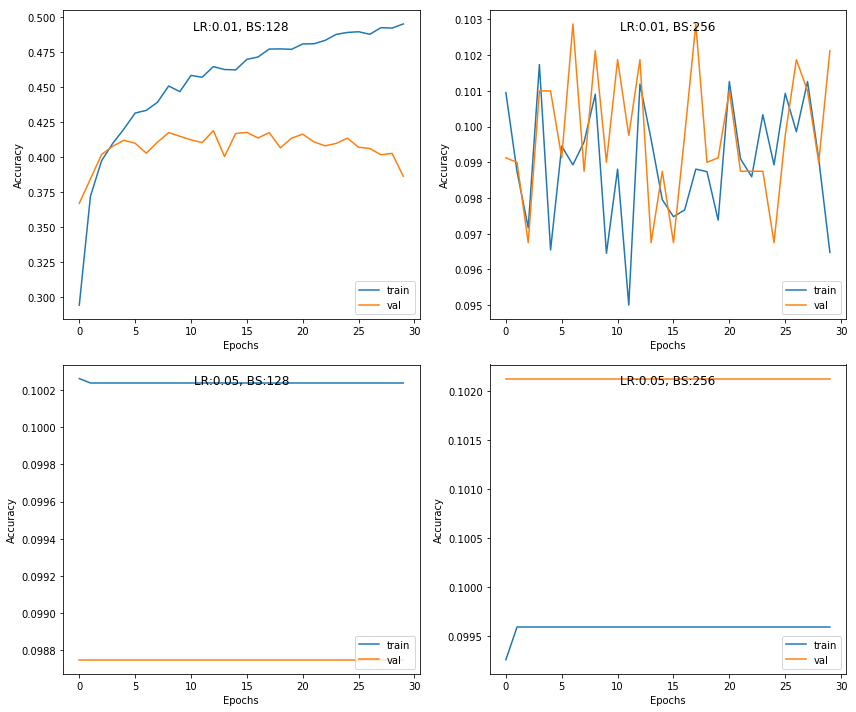

In [15]:
learning_rate = [0.01, 0.05]
batch_size = [128, 256]
grid = list(itertools.product(learning_rate, batch_size))
plt.figure(figsize=(12, 10))
for params in grid:
    print("Learning_rate: {}, Batch_size: {}".format(params[0], params[1]))
    plt.subplot(2, 2, grid.index(params) + 1)
    train_model(params[0], params[1], 30)
plt.tight_layout()
plt.show()

1. Only the combination of learning rate = 0.01 and batch size = 128 give reasonable values of training accuracy ~50%,  validation accuracy ~40% and test accuracy ~38%. Though they are still far from desirable.

###Influence of batch normalization on performance
1. Retrain the model with batch normalization on.
2. Evalute the model for various combinations of learning rates and batch sizes.

Learning_rate: 0.01, Batch_size: 128
Test Accuracy: 0.6356
Learning_rate: 0.01, Batch_size: 256
Test Accuracy: 0.5836
Learning_rate: 0.05, Batch_size: 128
Test Accuracy: 0.5553
Learning_rate: 0.05, Batch_size: 256
Test Accuracy: 0.6102


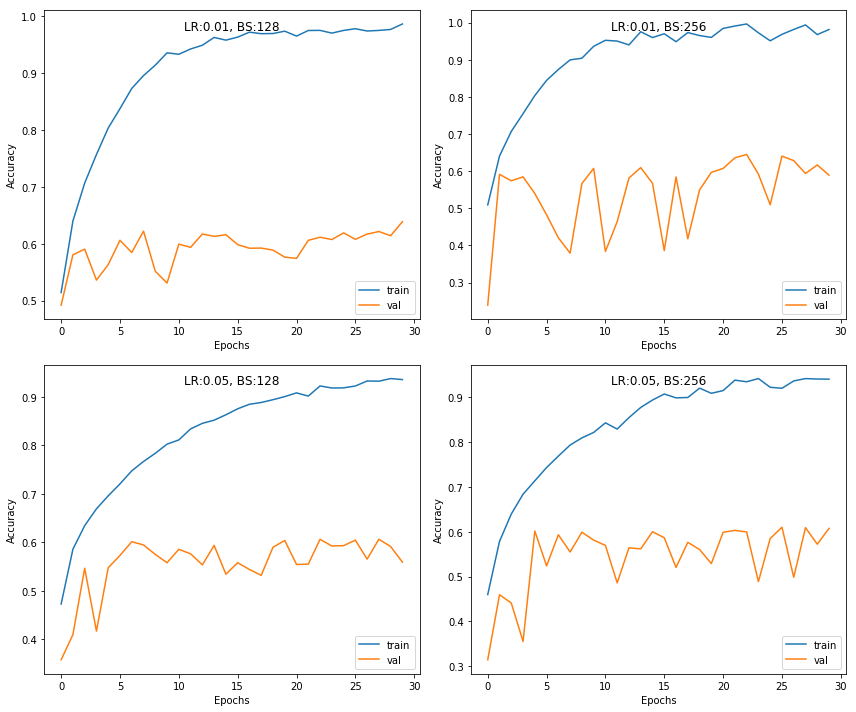

In [17]:
learning_rate = [0.01, 0.05]
batch_size = [128, 256]
grid = list(itertools.product(learning_rate, batch_size))
plt.figure(figsize=(12, 10))
for params in grid:
    print("Learning_rate: {}, Batch_size: {}".format(params[0], params[1]))
    plt.subplot(2, 2, grid.index(params) + 1)
    train_model(params[0], params[1], 30)
plt.tight_layout()
plt.show()

1. Using batch normalization improves the performance significantly for all combinations of learning rates and batch sizes.
2. Training accuracy now reaches ~98%, validation and test accuracy are ~60%.
3. However the significant gap between training and validation accuracy shows that overfitting is happening. Regularization would help in reducing the overfitting.

### Influence of dropout on performance

Learning_rate: 0.01, Batch_size: 128
Test Accuracy: 0.643
Learning_rate: 0.01, Batch_size: 256
Test Accuracy: 0.65
Learning_rate: 0.05, Batch_size: 128
Test Accuracy: 0.6292
Learning_rate: 0.05, Batch_size: 256
Test Accuracy: 0.6157


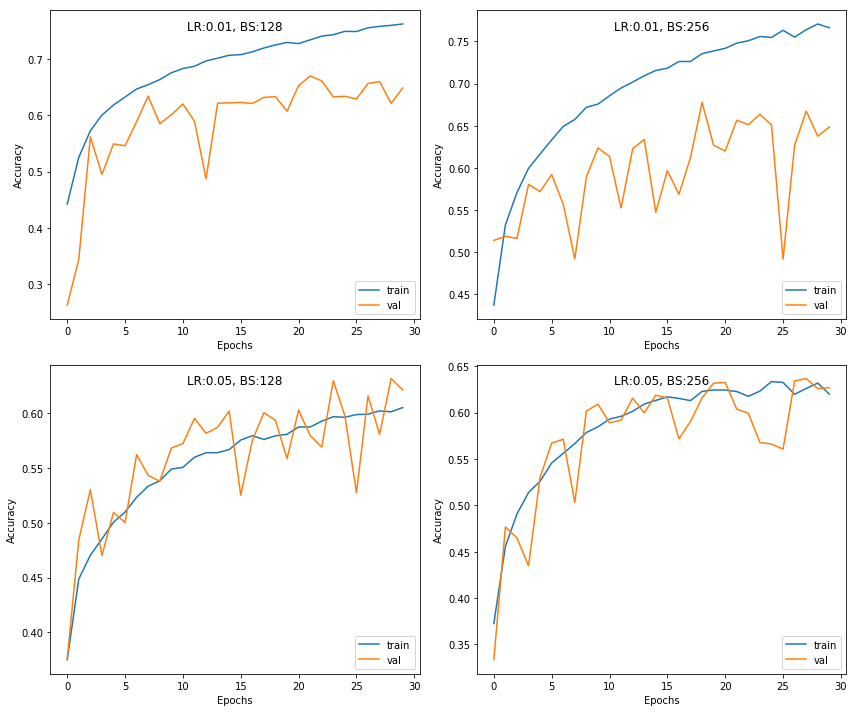

In [21]:
learning_rate = [0.01, 0.05]
batch_size = [128, 256]
grid = list(itertools.product(learning_rate, batch_size))
plt.figure(figsize=(12, 10))
for params in grid:
    print("Learning_rate: {}, Batch_size: {}".format(params[0], params[1]))
    plt.subplot(2, 2, grid.index(params) + 1)
    train_model(params[0], params[1], 30)
plt.tight_layout()
plt.show()

Dropout helps in closing the gap between training and validation accuracy and improves the latter. However, the overall test accuracy of the model still remains between 60-65%. Thus a more complex network architecture may be required to further improve performance.